# Anomaly detection on CPU usage

**Step 1** Import librarys

In [1]:
!pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 114.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 105.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 27.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 122.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 115.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━

In [2]:
import pandas as pd
import numpy as np 

from datetime import datetime

import seaborn as sns
import cufflinks as cf
import plotly.offline as py
import matplotlib.pyplot as plt

from pylab import rcParams
import statsmodels.api as sm

from pmdarima.arima import auto_arima
import pickle

**Step 2** Load datasets

In [3]:
url_train_a='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv'
url_train_b='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv'
url_test_a='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv'
url_test_b='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv'

train_a=pd.read_csv(url_train_a)
train_b=pd.read_csv(url_train_b)
test_a=pd.read_csv(url_test_a)
test_b=pd.read_csv(url_test_b)

**Step 3** Dataset overview

In [4]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [5]:
train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [6]:
train_a['datetime']=train_a['datetime'].astype('datetime64')
train_b['datetime']=train_b['datetime'].astype('datetime64')
test_a['datetime']=test_a['datetime'].astype('datetime64')
test_b['datetime']=test_b['datetime'].astype('datetime64')

In [7]:
train_a.describe(datetime_is_numeric=True)

datetime         cpu
count                            420  420.000000
mean   2017-01-27 22:11:29.999999744    1.233262
min              2017-01-27 18:42:00    0.570000
25%              2017-01-27 20:26:45    0.787500
50%              2017-01-27 22:11:30    1.110000
75%              2017-01-27 23:56:15    1.582500
max              2017-01-28 01:41:00    2.550000
std                              NaN    0.505668

In [8]:
train_b.describe(datetime_is_numeric=True)

datetime         cpu
count                  600  600.000000
mean   2017-01-27 23:41:30    1.282733
min    2017-01-27 18:42:00    0.570000
25%    2017-01-27 21:11:45    0.840000
50%    2017-01-27 23:41:30    1.240000
75%    2017-01-28 02:11:15    1.610000
max    2017-01-28 04:41:00    2.550000
std                    NaN    0.484951

In [9]:
test_a.describe(datetime_is_numeric=True)

datetime        cpu
count                             60  60.000000
mean   2017-01-28 02:11:29.999999744   1.271500
min              2017-01-28 01:42:00   0.680000
25%              2017-01-28 01:56:45   0.902500
50%              2017-01-28 02:11:30   1.210000
75%              2017-01-28 02:26:15   1.562500
max              2017-01-28 02:41:00   2.190000
std                              NaN   0.418309

In [10]:
test_b.describe(datetime_is_numeric=True)

datetime        cpu
count                   60  60.000000
mean   2017-01-28 05:11:30   1.345833
min    2017-01-28 04:42:00   0.030000
25%    2017-01-28 04:56:45   0.070000
50%    2017-01-28 05:11:30   1.605000
75%    2017-01-28 05:26:15   2.150000
max    2017-01-28 05:41:00   2.830000
std                    NaN   0.954620

We can see that train_a and test_a overlap in dates, the same is true for train_b and test_b. So, we assume that each group makes up a data set and for each dataset we will fit the same model and see how it fits.

In [36]:
train_a.set_index('datetime',inplace=True)
test_a.set_index('datetime',inplace=True)
train_b.set_index('datetime',inplace=True)
test_b.set_index('datetime',inplace=True)

In [12]:
train_a.sample(10)

cpu
datetime                 
2017-01-27 20:32:00  1.40
2017-01-27 23:09:00  1.50
2017-01-28 00:39:00  0.99
2017-01-28 01:26:00  2.07
2017-01-28 01:18:00  2.10
2017-01-27 19:49:00  0.65
2017-01-27 19:43:00  0.62
2017-01-27 23:45:00  1.20
2017-01-27 23:34:00  1.25
2017-01-27 19:14:00  0.74

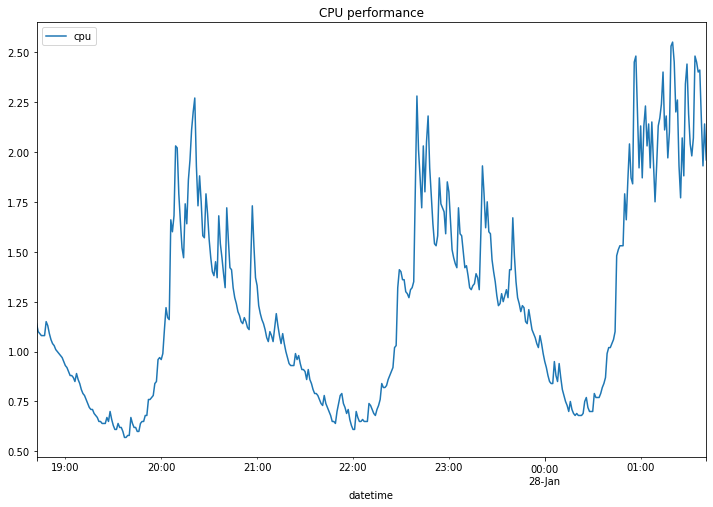

In [13]:
train_a.plot(title='CPU performance',figsize=(12,8))
plt.show()

It looks like there is a seasonality each two hours and a trend, altought it is very low. Maybe with a descomposition analysis it is easier to see.

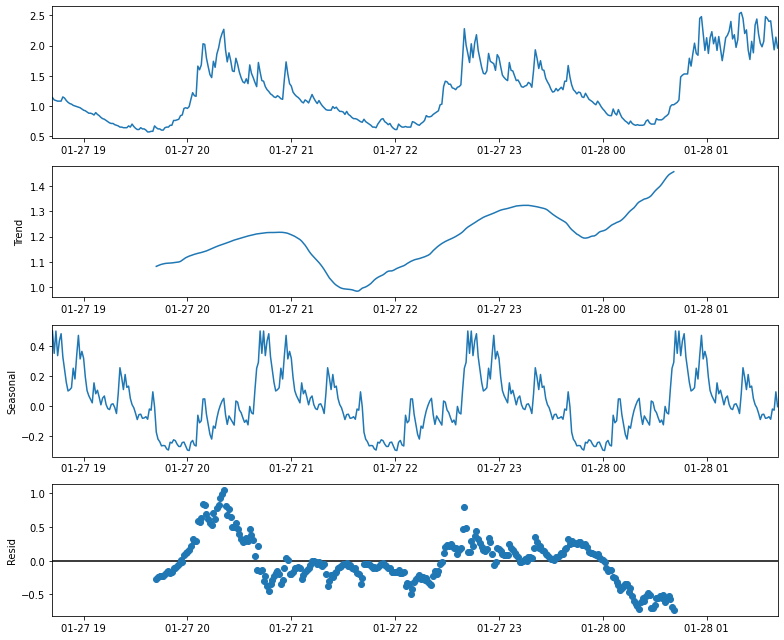

In [14]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(train_a,model='additive',period=60*2) # 2 hours period, the datetime is in minutes
fig = decomposition.plot()
plt.show()

Although we have a few observations to say anything with any certainty, we can see the seasonal component of the data, and we can also see a slightly upward trend of the data. It makes sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

**Step 4** Seasonal ARIMA model

Looking for the best parameters.

In [15]:
stepwise_model = auto_arima(train_a, start_p=1, start_q=1,
                           max_p=1, max_q=1, m=60*2,
                           start_P=0, seasonal=True,
                           d=1, D=1,max_P=1,max_Q=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,random_state=608)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[120]             : AIC=inf, Time=228.06 sec
 ARIMA(0,1,0)(0,1,0)[120]             : AIC=-187.268, Time=28.31 sec
 ARIMA(1,1,0)(1,1,0)[120]             : AIC=inf, Time=112.61 sec
 ARIMA(0,1,1)(0,1,1)[120]             : AIC=inf, Time=213.43 sec
 ARIMA(0,1,0)(1,1,0)[120]             : AIC=inf, Time=90.30 sec
 ARIMA(0,1,0)(0,1,1)[120]             : AIC=inf, Time=165.20 sec
 ARIMA(0,1,0)(1,1,1)[120]             : AIC=inf, Time=150.59 sec
 ARIMA(1,1,0)(0,1,0)[120]             : AIC=-185.492, Time=10.33 sec
 ARIMA(0,1,1)(0,1,0)[120]             : AIC=-185.580, Time=12.60 sec
 ARIMA(1,1,1)(0,1,0)[120]             : AIC=-189.254, Time=34.08 sec
 ARIMA(1,1,1)(1,1,0)[120]             : AIC=-241.022, Time=159.71 sec
 ARIMA(1,1,1)(1,1,1)[120]             : AIC=inf, Time=485.10 sec
 ARIMA(0,1,1)(1,1,0)[120]             : AIC=-239.632, Time=104.99 sec
 ARIMA(1,1,1)(1,1,0)[120] intercept   : AIC=-239.067, Time=312.73 sec

Best model:  ARI

In [16]:
stepwise_model.fit(train_a) #fit the best model

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 120),
      suppress_warnings=True, with_intercept=False)

**Step 5** Evaluate the performance

Visual evaluation

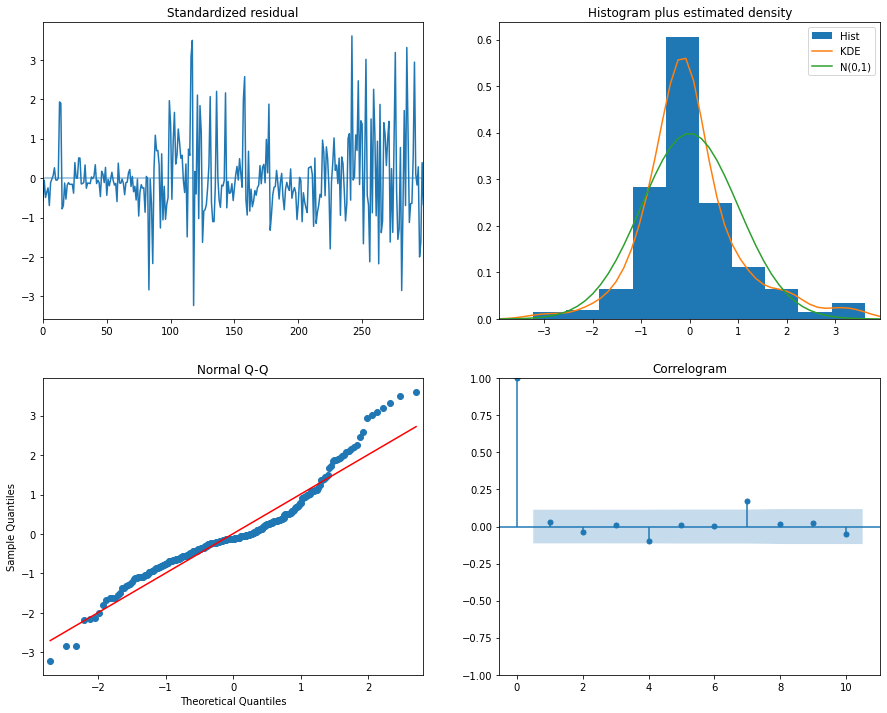

In [17]:
stepwise_model.fit(train_a).plot_diagnostics(figsize=(15, 12))
plt.show()

This is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.

It is observed that the distribution of the residuals does not fit perfectly to a standard normal distribution. One could try to run the model by increasing the maximum number of residuals included, the differences and the moving averages, both the structural and the seasonal components.

Note: an attempt was made to run a model with a maximum of 2 residuals and 2 differences but it took a long time (indeed it run for 6 hours) and the session was closed.

Forcasting with the model fitted

In [30]:
future_forecast_a = stepwise_model.predict(n_periods=60) # One hour forcast

**Step 6** Actual plus prediction // Real future plus prediction

<AxesSubplot:title={'center':'Actual plus predict CPU incidences'}, xlabel='datetime'>

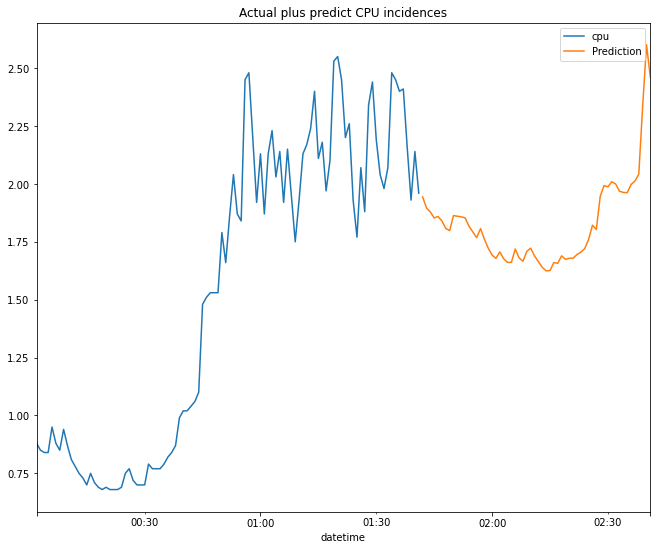

In [31]:
future_forecast_a = pd.DataFrame(future_forecast_a,index = test_a.index,columns=['Prediction'])
pd.concat([train_a.tail(100),future_forecast_a],axis=0).plot(title='Actual plus predict CPU incidences')

It is observed that the forecast reflects the decrease at 2 am respecting the seasonal component.

<AxesSubplot:title={'center':'Real future plus predict CPU incidences'}, xlabel='datetime'>

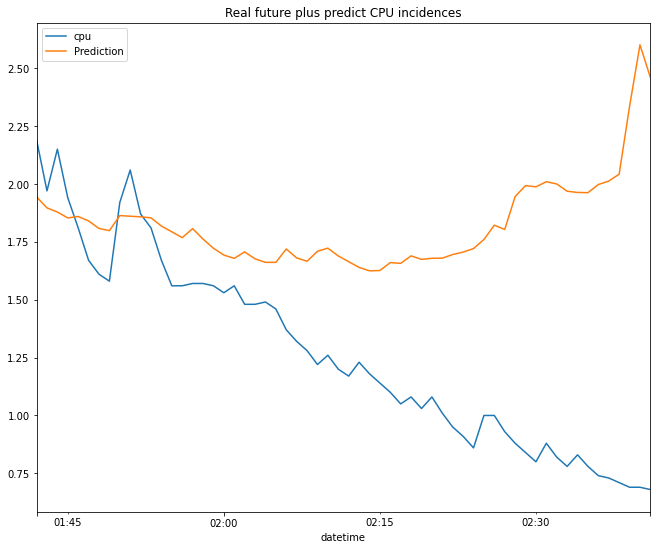

In [33]:
pd.concat([test_a,future_forecast_a],axis=1).plot(title='Real future plus predict CPU incidences')

On one hand, it is observed that the training sample does not seem to have the same seasonal behavior as the training sample; in fact, the incidences do not increase after the two, but seem to continue to decrease. On the other hand, related to the above, the prediction made by the model is far from reality.

In [34]:
# Save the model as a pickle
filename = '../models/best_model_a.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))

**Step 7** Refitting the model

In [37]:
stepwise_model.fit(train_b)
future_forecast_b = stepwise_model.predict(n_periods=60)

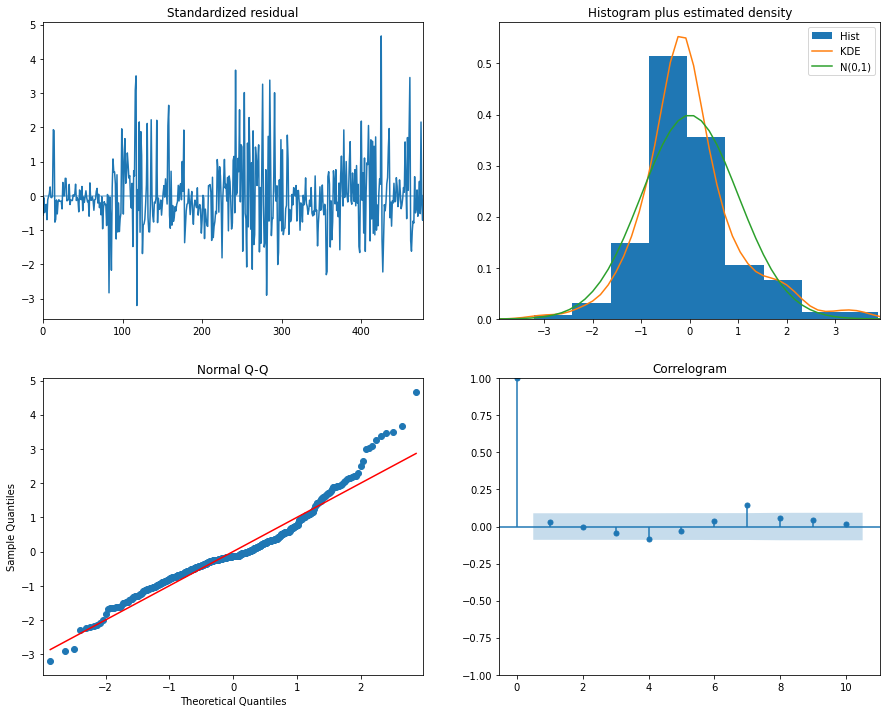

In [38]:
stepwise_model.fit(train_b).plot_diagnostics(figsize=(15, 12))
plt.show()

It was the same as with the other training test.

<AxesSubplot:title={'center':'Real future plus predict CPU incidences'}, xlabel='datetime'>

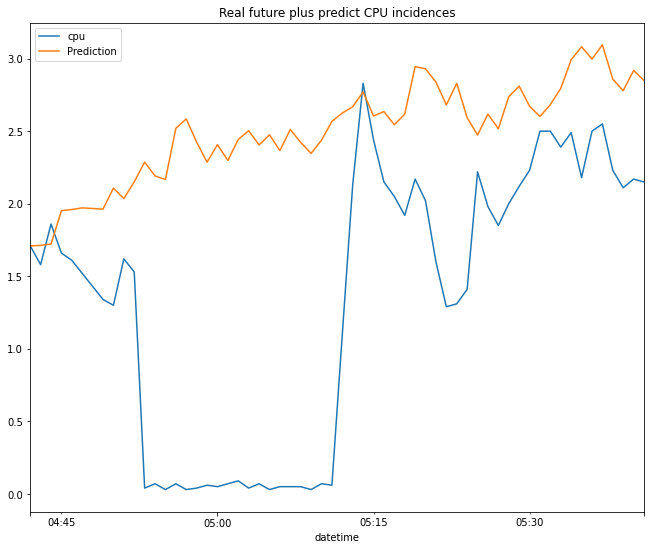

In [39]:
future_forecast_b = pd.DataFrame(future_forecast_b,index = test_b.index,columns=['Prediction'])
pd.concat([test_b,future_forecast_b],axis=1).plot(title='Real future plus predict CPU incidences')

However, in the sample of test b there is a sharp decrease at 5 am that does not coincide with the seasonal component. It seems to be an outlier, so it is impossible to predict. In fact, if we look at the rest of the prediction, it seems to be very close to reality.

In [40]:
# Save the model as a pickle
filename = '../models/best_model_b.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))